# ML-7. Оптимизация гиперпараметров модели

## 1. Введение

Цели модуля:
* Узнать, какие есть базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV);
* Узнать, какие есть продвинутые способами оптимизации (Hyperopt, Optuna);
* Научиться их настраивать и обучать модели с их использованием,  так, чтобы улучшать итоговую метрику.  
* Провести сравнение и понять преимущества и недостатки каждого из методов


## 2. Базовая оптимизация

In [1]:
# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные моделиё
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn import model_selection
from sklearn.model_selection import train_test_split # сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

### Описание задачи

Продолжим решать задачу кассификации из модуля ML-3: "Предсказание категории дохода человека"

Данные, с которыми мы будем работать были извлечены из базы данных **Бюро переписи населения 1994 года** Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной - предсказание дохода.

Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50K $.


Данные, с которыми мы будем работать, были извлечены из базы данных Бюро переписи населения 1994 года Ронни Кохави и Барри Беккером (интеллектуальный анализ данных и визуализация, Silicon Graphics). Датасет содержит информацию о людях и их доходе. В оригинальном датасете задача была регрессионной и заключалась в предсказании дохода. Мы будем использовать версию датасета, где доход участников переписи разделен на две категории: больше и меньше (либо равен) 50 000 $.

Признаки:
* age — возраст
* workclass — сфера занятости
* fnlwgt — общий вес (число людей, которых, по мнению эксперта, представляет эта категория занятости)
* education — уровень образования
* education.num — образовательная ступень (в виде числа)
* marital.status — семейное положение
* occupation — род деятельности
* relationship — родственные отношения
* race — раса
* sex — пол
* capital.gain — ежегодный дополнительный прирост капитала
* capital.loss — ежегодная дополнительная потеря капитала
* hours.per.week — число рабочих часов в неделю
* native.country — страна рождения
* income — категория дохода (целевой признак — более 50К $ или менее 50К $)

### Знакомство с данными и их исследование

In [2]:
# ЕСЛИ РАБОТАЕМ В IDE
data = pd.read_csv('data/adult.zip')

# ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
# from google.colab import drive
# drive.mount('/content/drive')
# # берем необходимый нам файл с диска, указав путь
# data = pd.read_csv('./drive/MyDrive/SF/SF module 7/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


Признаки:
* age - возраст
* workclass - статус занятости
* fnlwgt - общий вес, это число людей, которых, по мнению эксперта, представляет эта категория занятости
* education - образование
* education.num - образовательная ступень (в виде числа)
* marital.status - брачный статус
* occupation - профессия
* relationship - тип отношений
* race - раса
* sex - пол
* capital.gain - ежегодный дополнительный прирост капитала
* capital.loss - ежегодная дополнительная потеря капитала
* hours.per.week - число рабочих часов в неделю
* native.country - Родина 
* income - категория дохода (целевой признак)

Проверяем наличие пропусков

In [3]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [4]:
data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


Смотрим на сбалансированность классов:

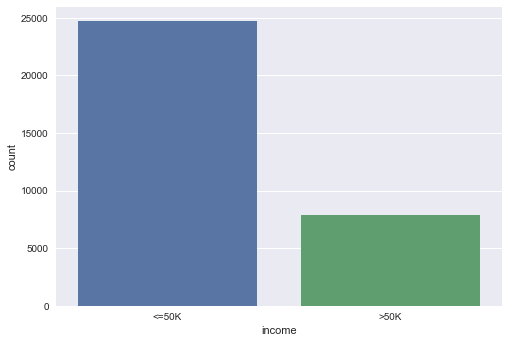

In [5]:
sns.countplot(data=data, x='income');

Для удобства переобозначим целевой признак (не обязательный шаг)

In [6]:
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

Исследуем категориальные признаки

In [7]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

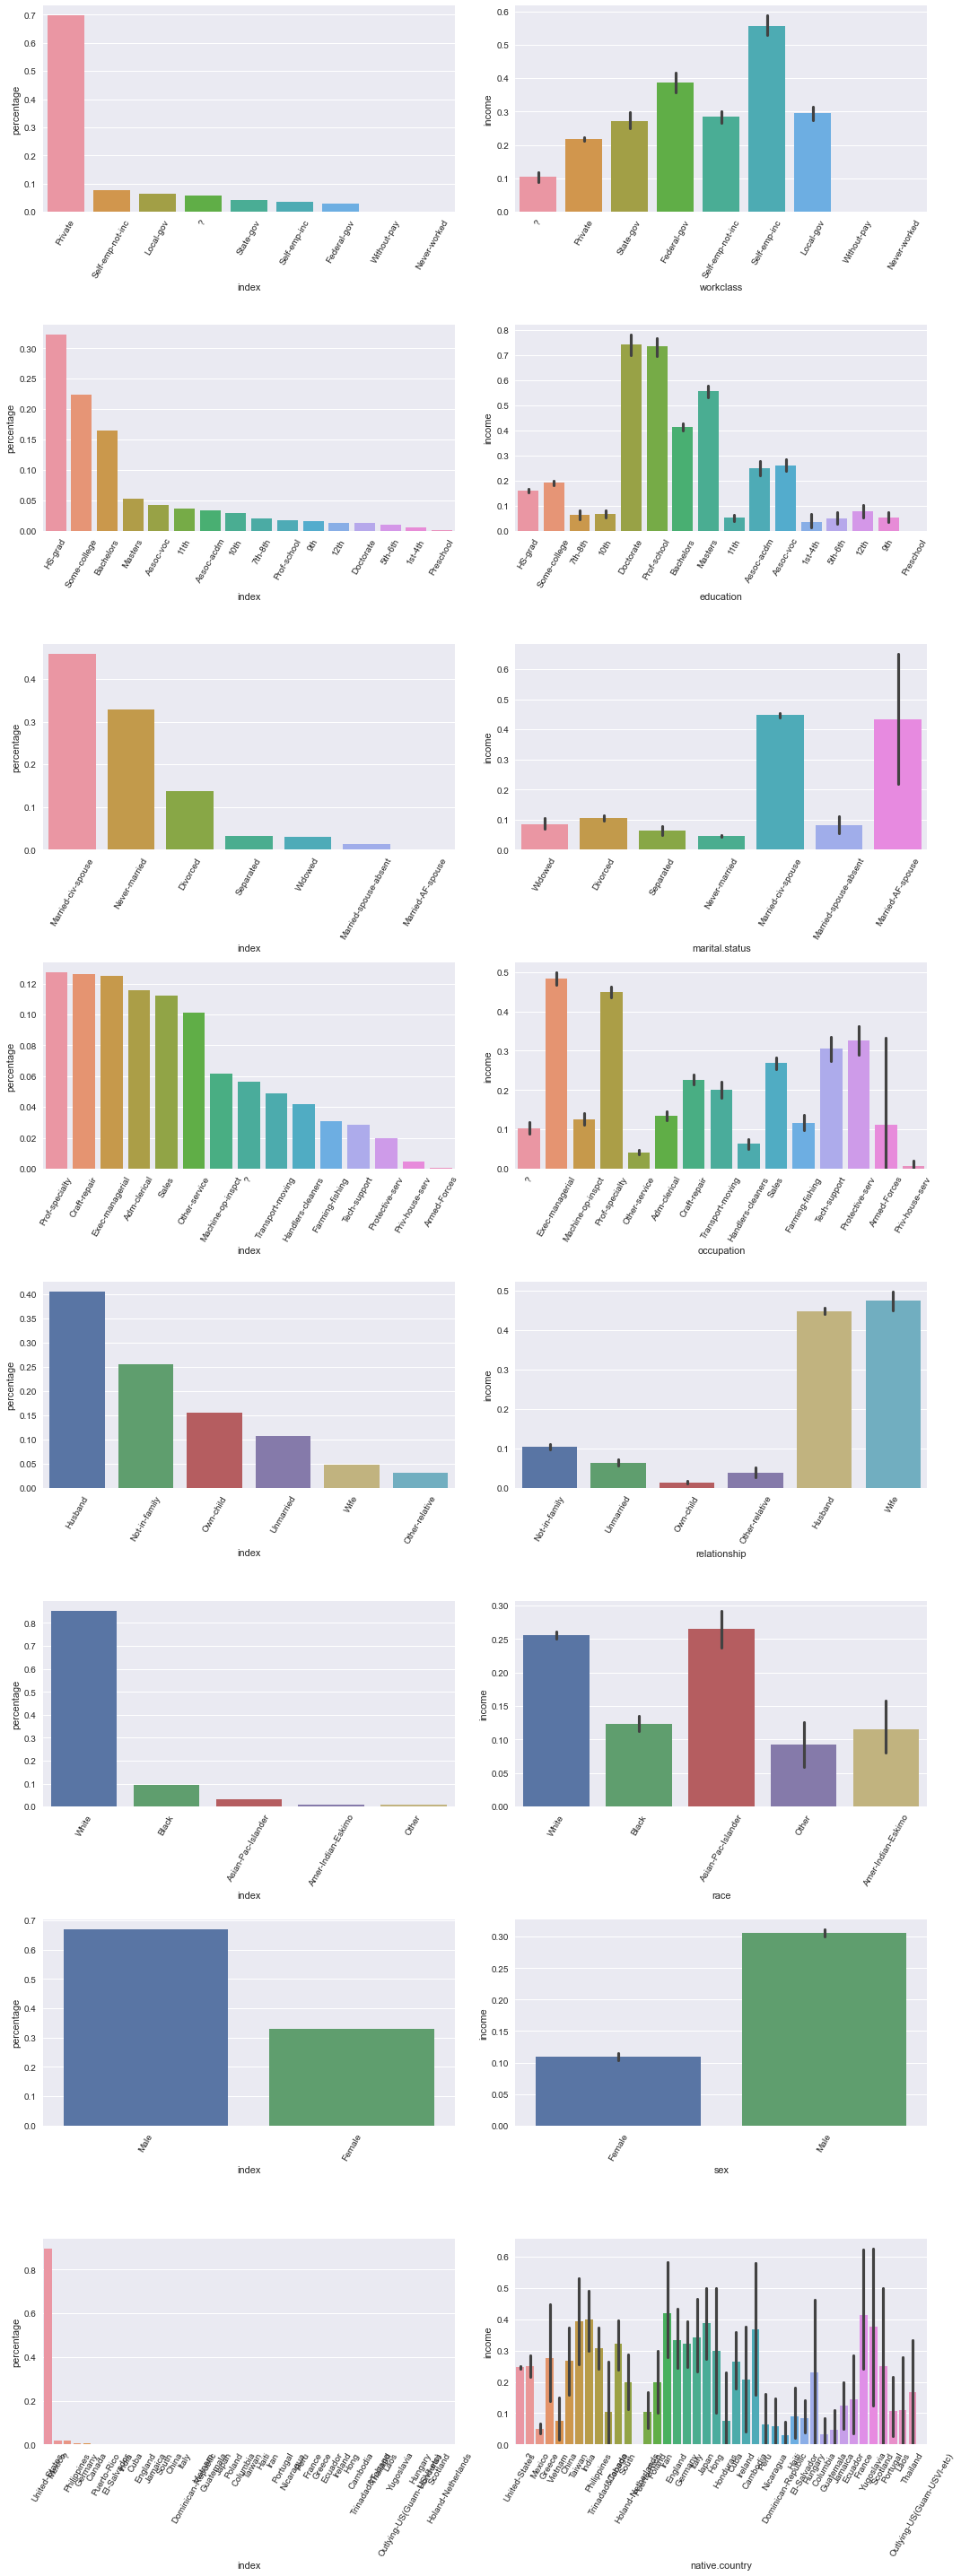

In [8]:
n = len(cat_features) # число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # фигура+n*2 координатных плоскостей

# Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    # Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (data[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    
    # Строим столбчатую диаграмму доли людей зарабатывающих >50K 
    # (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
    
plt.tight_layout() # выравнивание графиков

### Подготовка данных (предобработка)

Предобрабатываем категориальые признаки: уменьшаем количество категорий

In [9]:
adult_data = data.copy()

# Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)

# Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)

# Объединяем вдовцов, разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)

# Объединяем всех женатых/ за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)

# Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

# Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)

# Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

Предобрабатываем числовые признаки

In [10]:
# Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain'] + 1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss'] + 1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt'] + 1)

# Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [11]:
# Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

Проверяем результаты предобработки

In [12]:
adult_data.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
count,32561,32561,32561,32561,32561,32561,32561,32561
unique,8,9,3,15,2,5,2,2
top,Private,HS-grad,Married,Prof-specialty,Not in relationship,White,Male,United-States
freq,22696,10501,15417,4140,19368,27816,21790,29170


Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

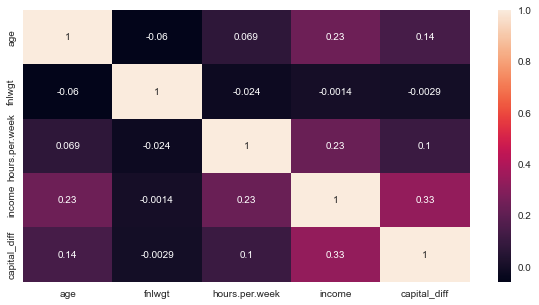

In [13]:
plt.figure(figsize = (10, 5))
sns.heatmap(adult_data.corr(), annot = True);

Кодируем текстовые категориальные признаки

In [14]:
dummies_data = pd.get_dummies(adult_data, drop_first=True)
dummies_data.head()

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [15]:
X, y = dummies_data.drop(['income'], axis=1), dummies_data['income']

* Разделяем выборку на тренировочную и тестовую в соотношении 80/20. 
* Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [17]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [18]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.84
f1_score на train наборе: 0.64

accuracy_score на test наборе: 0.84
f1_score на test наборе: 0.64


## 3. Продвинутая оптимизация.

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации, поэтому в идеале мы хотим делать это самым эффективным образом. Один из способов  — это выбор следующей комбинации гиперпараметров на основе прошлых результатов. 
Байесовская оптимизация отличается от случайного поиска или поиска по сетке тем, что делает именно это: вместо того, чтобы просто выбирать комбинации из сетки, не имеющей информации о прошлых оценках, байесовские методы учитывают предыдущие результаты, чтобы попробовать более многообещающие комбинации значений. Это позволяет во многих случаях найти лучшие значения гиперпараметров модели за меньшее количество времени.
Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей машинного обучения.

## <center> Optuna

Optuna - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

In [19]:
# Устанавливаем библиотеку
# !pip install optuna
# или
#!conda install -c conda-forge optuna

In [20]:
import optuna
print(f'Версия Optuna: {optuna.__version__}')

Версия Optuna: 2.10.1


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [21]:
random_state = 42

In [31]:
def optuna_rf(trial, cv=5):
  """ Функция для оптимизации

  Args:
      trial (_type_): _description_
      cv (int, optional): Количество фолдов кросс-валидации. По умолчанию 0, кросс-валидация не используется.

  Returns:
      _type_: _description_
  """
  
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
  max_depth = trial.suggest_int('max_depth', 5, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 15, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
  if cv > 0:
    # Создаём объект кросс-валидатора k-fold со стратификацией
    skf = model_selection.StratifiedKFold(n_splits=cv)
    
    # Считаем метрики на кросс-валидации k-fold со стратификацией
    cv_metrics = model_selection.cross_validate(
        estimator=model, # модель
        X=X_train_scaled, # матрица наблюдений X
        y=y_train, # вектор ответов y
        cv=skf, # кросс-валидатор
        scoring='f1', # метрика
        return_train_score=False # подсчёт метрики на тренировочных фолдах
    )
    score = np.mean(cv_metrics['test_score'])
  else:
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  
  return score

In [32]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику через direction
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-09-12 15:42:39,821] A new study created in memory with name: RandomForestClassifier
[I 2022-09-12 15:42:50,040] Trial 0 finished with value: 0.6474246367031908 and parameters: {'n_estimators': 167, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6474246367031908.
[I 2022-09-12 15:42:57,454] Trial 1 finished with value: 0.6237808878863318 and parameters: {'n_estimators': 140, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6474246367031908.
[I 2022-09-12 15:43:09,522] Trial 2 finished with value: 0.6512939148527129 and parameters: {'n_estimators': 196, 'max_depth': 20, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6512939148527129.
[I 2022-09-12 15:43:18,979] Trial 3 finished with value: 0.6383394380761465 and parameters: {'n_estimators': 151, 'max_depth': 17, 'min_samples_leaf': 14}. Best is trial 2 with value: 0.6512939148527129.
[I 2022-09-12 15:43:37,952] Trial 4 finished with value: 0.6437371066580899 and parameters: {'n

CPU times: total: 4min 50s
Wall time: 4min 56s


In [33]:
# выводим результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value:.2f}')

Наилучшие значения гиперпараметров {'n_estimators': 299, 'max_depth': 29, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.67


In [34]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state,)

# Обучаем модель
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.92
f1_score на train наборе: 0.82

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.68


In [35]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(n_estimators=299, max_depth=29, min_samples_leaf=2, random_state=random_state,)

# Обучаем модель
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.92
f1_score на train наборе: 0.82

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.68


In [27]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2022-09-12 14:00:09,565] Trial 20 finished with value: 0.702648401826484 and parameters: {'n_estimators': 262, 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 17 with value: 0.8130296610169492.
[I 2022-09-12 14:00:13,542] Trial 21 finished with value: 0.7948148805824381 and parameters: {'n_estimators': 196, 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.8130296610169492.
[I 2022-09-12 14:00:16,932] Trial 22 finished with value: 0.7552761562640323 and parameters: {'n_estimators': 171, 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 17 with value: 0.8130296610169492.
[I 2022-09-12 14:00:20,519] Trial 23 finished with value: 0.7388454978005208 and parameters: {'n_estimators': 183, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.8130296610169492.
[I 2022-09-12 14:00:23,577] Trial 24 finished with value: 0.7585529254131308 and parameters: {'n_estimators': 146, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 17 with val

CPU times: total: 40.1 s
Wall time: 40.1 s


In [28]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )

# Обучаем модель
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.92
f1_score на train наборе: 0.81

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.67


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [29]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [30]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [31]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [32]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Точки с белым фоном это и есть лучшии комбинации n_estimator, max_depth.
















### Задание 3.10
Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:
* n_estimators = от 100 до 300 включительно с шагом 10
* min_samples_leaf = от 3 до 7 с шагом 1
* max_depth = от 15 до 40 с шагом 1

Используйте Optuna с параметрами n_trails = 20.

In [33]:
def optuna_rf(trial, cv=0):
  """ Функция для оптимизации

  Args:
      trial (_type_): _description_
      cv (int, optional): Количество фолдов кросс-валидации. По умолчанию 0, кросс-валидация не используется.

  Returns:
      _type_: _description_
  """
  
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
  if cv > 0:
    # Создаём объект кросс-валидатора k-fold со стратификацией
    skf = model_selection.StratifiedKFold(n_splits=cv)
    
    # Считаем метрики на кросс-валидации k-fold со стратификацией
    cv_metrics = model_selection.cross_validate(
        estimator=model, # модель
        X=X_train_scaled, # матрица наблюдений X
        y=y_train, # вектор ответов y
        cv=skf, # кросс-валидатор
        scoring='f1', # метрика
        n_jobs=-1,
        return_train_score=False # подсчёт метрики на тренировочных фолдах
    )
    score = np.mean(cv_metrics['test_score'])
  else:
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  
  return score

In [34]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику через direction
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf(cv=5), n_trials=20)

[I 2022-09-12 14:00:51,242] A new study created in memory with name: RandomForestClassifier


TypeError: optuna_rf() missing 1 required positional argument: 'trial'

In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )

# Обучаем модель
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.90
f1_score на train наборе: 0.77

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.68
